# Parse data structure into a pandas DataFrame
Parse data paths from the Smart-Kages folder structure and store them in a pandas DataFrames.

Also, load time adjustments to help estimate start and end times for each 1-hour segment.

In [32]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sleap_io as sio

from smart_kages_movement.datetime import (
    extract_datetimes,
    extract_frame_timestamps,
    find_segment_overlaps,
)
from smart_kages_movement.io import parse_data_into_df
from smart_kages_movement.plots import show_first_frame_corner

## Configuration
Define some global variables and paths.

In [ ]:
# Path to the data directory containing all kages.
data_dir = Path.home() / "Data" / "Smart-Kages"
assert data_dir.exists(), f"Data directory {data_dir} does not exist."

# Path for saving the processed data (in this case, a subfolder of 'data_dir').
save_dir = data_dir / "movement_analysis"
save_dir.mkdir(parents=True, exist_ok=True)

## Aggregate segment paths into a single dataframe

The data is stored per Smart-Kage, in folders names as `kageN`, e.g. `kage1`, `kage2`, etc.

Each Smart-Kage folder contains:
- daily videos are stored in `videos/YYYY/MM/DD/`, split into 1-hour segments. Each 1-hour segment is an `.mp4` file named `kageN_YYYYMMDD_HHMMSS.mp4`.
- corresponding DeepLabCut (DLC) predictions are stored in `analysis/dlc_output/YYYY/MM/DD/`. Each 1-hour `.h5` file therein is prefixed with `kageN_YYYYMMDD_HHMMSS`.

Let's parse the relevant parts of the data structure into a single dataframe.

In [34]:
df = parse_data_into_df(data_dir)
df.head()

Found 1 kage directories:  kage10
Found a total of 859 .h5 pose files output by DLC.


start_datetime  \
kage   date     hour                       
kage10 20240403 00   2024-04-03 00:00:02   
                01   2024-04-03 01:00:01   
                02   2024-04-03 02:00:02   
                03   2024-04-03 03:00:02   
                04   2024-04-03 04:00:02   

                                                         pose_file_path  \
kage   date     hour                                                      
kage10 20240403 00    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                01    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                02    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                03    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...   

                                                        video_file_path  
kage   date     hour                                                     
kage10 20240403 00    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                01    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                02    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                03    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...

## Add some video metadata
We reach each video's `n_frames`, `height`, `width`, and `n_channels` from the video file itself, using `sleap-io`.

These metadata are added as columns to the dataframe.

In [35]:
video_shapes = pd.DataFrame(
    np.zeros((len(df), 4), dtype=int),
    index=df.index,
    columns=["n_frames", "height", "width", "n_channels"],
)

for idx, row in df.iterrows():
    video_path = row["video_file_path"]
    video = sio.load_video(video_path)  # Lazy-Load the video using sleap_io
    # Extract video shape information
    video_shapes.loc[idx, "n_frames"] = video.shape[0]
    video_shapes.loc[idx, "height"] = video.shape[1]
    video_shapes.loc[idx, "width"] = video.shape[2]
    video_shapes.loc[idx, "n_channels"] = (
        video.shape[3] if len(video.shape) > 3 else 1
    )
    video.close()  # Close the video to free resources

# Concatenate the video shapes with the original DataFrame
df = pd.concat([df, video_shapes], axis=1)

Let's see if there are any videos where `n_channels` is not 3, which would indicate a non-RGB video.

In [36]:
df_non_rgb = df[df["n_channels"] != 3]
print(f"Founcd {len(df_non_rgb)} non-RGB videos.")
df_non_rgb.head(len(df_non_rgb))

Founcd 0 non-RGB videos.


,,,start_datetime,pose_file_path,video_file_path,n_frames,height,width,n_channels
kage,date,hour,,,,,,,


## Adjust datetimes for each segment
Above, we derived the start datetime of each video from its filename.
However, this is usually not the exact time when the video started recording.

We can find the exact start time for each video, as well as the exact timestamps for each frame, by inspecting two sources:

1. The `adjustments.txt` file. There is one per day, stored in `kageN/videos/YYYY/MM/DD/`, and contains one row per video file, formatted as `video_file:H,M,S`. For example, this could be `kage1_20240420_000002.mp4:0,0,6`. The hours, minutes, and seconds represent the offset relative to time `00:00:00` of that day. These values are extracted from the first video frame using computer vision. Negative, or otherwise impossible values indicate an error in this extraction process.

2. The `corrected_timestamps.pkl` file. There is one per day, stored in `kageN/analysis/dlc_output/YYYY/MM/DD/`. This file contains a dictionary mapping each pose filename to an array of corrected timestamps, expressed in seconds since the start of the hour. The first element should match the offset in the `adjustments.txt` file, and the rest should be derived by adding the frame timestamps (extracted from the .mp4 file) to this offset.

As a result of this process, the dataframe `df` will now have a `start_datetime` column with the exact start time of each video. Moreover, we will obtain a `frame_timestamps` dictionary, mapping each video segment, identified by a `(kage, date, hour)` tuple, to an array of timestamps expressed in seconds elapsed since the start of each video.

In [37]:
df, frame_timestamps = extract_datetimes(df)

/tmp/ipykernel_2913256/2965125456.py:1: UserWarning: First timestamp for kage10_20240508_160238DLC_resnet101_v2Jan17shuffle2_580000.h5 does not match the adjustment for kage10_20240508_160238.mp4. Setting start_datetime to NaT.
  df, frame_timestamps = extract_datetimes(df)


### Quality control 1: start datetime mismatches between `adjustments.txt` and `corrected_timestamps.pkl`
Some warnings may have appeared during the adjustment, flagging invalid adjustments values or mismatches between the `adjustments.txt` and the `corrected_timestamps.pkl`. We have marked all such problematic segments as having a `start_datetime` of `NaT` (Not a Time) in the dataframe.

In [38]:
invalid_datetimes = df[df["start_datetime"].isna()]
if not invalid_datetimes.empty:
    print(
        f"Found {len(invalid_datetimes)} videos with invalid adjustments",
        "or mismatches between the adjustment and corrected_timestamps.pkl.",
    )
else:
    print("All videos have valid start_datetimes.")

invalid_datetimes[["start_datetime"]]

Found 1 videos with invalid adjustments or mismatches between the adjustment and corrected_timestamps.pkl.


,,,start_datetime
kage,date,hour,
kage10,20240508,16,NaT


We can open the first frame of each problematic video and look at the timestamps burned into the top-left corner.

('kage10', '20240508', '16')


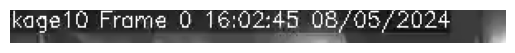

In [39]:
for idx, row in invalid_datetimes.iterrows():
    print(idx)
    show_first_frame_corner(row["video_file_path"])

Below, we will manually enter the correct start datetimes for each problematic video,
as a dictionary mapping `(kage, date, hour)` tuples to datetimes in the format `YYYY-MM-DD HH:MM:SS`.
If there are no problematic videos, this dictionary can be empty.

In [40]:
manual_start_datetimes = {
    ("kage10", "20240508", "16"): "2024-05-08 16:02:45",
}

for (kage, date, hour), start_datetime in manual_start_datetimes.items():
    df.loc[(kage, date, hour), "start_datetime"] = pd.to_datetime(
        start_datetime, format="%Y-%m-%d %H:%M:%S"
    )

# All start datetimes should now be valid.
assert df["start_datetime"].notna().all(), "Some start datetimes are still NaT"

Now we can derive the precise datetime timestamps for each frame by adding the 
known `start_datetime` to the frame timestamps (which are in seconds elapsed).

We can also derive the `end_datetime` for each video as the last timestamp.

We also derive a `timestamps_datetime` dictionary, mapping each video segment, identified by a `(kage, date, hour)` tuple, to an array of precise datetime objects for each frame.

In [41]:
df["end_datetime"] = df["start_datetime"].copy()
timestamps_datetime = {}
for (kage, date, hour), seconds_elapsed in frame_timestamps.items():
    start_datetime = df.loc[(kage, date, hour), "start_datetime"]
    timedelta = pd.to_timedelta(seconds_elapsed, unit="s")
    datetime_stamps = start_datetime + timedelta
    # Derive the end datetimes from the last timestamp of each video.
    df.loc[(kage, date, hour), "end_datetime"] = datetime_stamps[-1]
    timestamps_datetime[(kage, date, hour)] = datetime_stamps

# Reorder columns for readability
df = df[
    [
        "start_datetime",
        "end_datetime",
        "n_frames",
        "n_channels",
        "height",
        "width",
        "pose_file_path",
        "video_file_path",
    ]
]
df.head()

start_datetime                  end_datetime  \
kage   date     hour                                                     
kage10 20240403 00   2024-04-03 00:00:06 2024-04-03 00:59:59.493364484   
                01   2024-04-03 01:00:05 2024-04-03 01:59:59.506578626   
                02   2024-04-03 02:00:06 2024-04-03 02:59:59.494565316   
                03   2024-04-03 03:00:06 2024-04-03 03:59:59.495557178   
                04   2024-04-03 04:00:06 2024-04-03 04:59:59.495144236   

                      n_frames  n_channels  height  width  \
kage   date     hour                                        
kage10 20240403 00        7189           3     376    500   
                01        7191           3     376    500   
                02        7189           3     376    500   
                03        7189           3     376    500   
                04        7189           3     376    500   

                                                         pose_file_path  \
kage   date     hour                                                      
kage10 20240403 00    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                01    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                02    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                03    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...   

                                                        video_file_path  
kage   date     hour                                                     
kage10 20240403 00    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                01    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                02    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                03    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...

### Quality control 2: Number of frames mismatch between video and timestamps
Let's check if the number of frame timestamps in each segment matches the number of frames in the video.
If some video frames are missing timestamps, we will extract them anew from the video file and fill the gaps with linear interpolation, if needed.
If this process still results in a mismatch, we will raise an error. Finally, we will update the `frame_timestamps` and `timestamps_datetime` dictionaries as well as the `end_datetime` column in the dataframe with the new corrected timestamps.

In [42]:
for (kage, date, hour), seconds_elapsed in frame_timestamps.items():
    n_frames = df.loc[(kage, date, hour), "n_frames"]
    if len(seconds_elapsed) != n_frames:
        print(
            f"Mismatch for {kage} {date} {hour}: {len(seconds_elapsed)} "
            f"frame timestamps vs {n_frames} video frames."
        )

        # Let's extract frame timestamps directly from the video
        # and interpolate missing timestamps if needed.
        new_seconds_elapsed = extract_frame_timestamps(
            df.loc[(kage, date, hour), "video_file_path"],
            expected_n_frames=n_frames,
        )

        # Check if the new timestamps now match the expected number of frames.
        if len(new_seconds_elapsed) != n_frames:
            raise ValueError(
                f"New timestamps length {len(new_seconds_elapsed)} still "
                f"does not match expected {n_frames} frames."
            )

        # Update the timestamps with the new ones.
        frame_timestamps[(kage, date, hour)] = new_seconds_elapsed
        # Re-compute datetime stamps from the known start datetime.
        start_datetime = df.loc[(kage, date, hour), "start_datetime"]
        timedelta = pd.to_timedelta(new_seconds_elapsed, unit="s")
        datetime_stamps = start_datetime + timedelta
        # Re-derive the end datetimes from the last timestamp of each video.
        df.loc[(kage, date, hour), "end_datetime"] = datetime_stamps[-1]
        timestamps_datetime[(kage, date, hour)] = datetime_stamps

Mismatch for kage10 20240414 10: 7188 frame timestamps vs 7189 video frames.


/tmp/ipykernel_2913256/2298045744.py:11: UserWarning: Video /ceph/neuroinformatics/neuroinformatics/sirmpilatzen/behav_data/Loukia/SmartKages/kage10/videos/2024/04/14/kage10_20240414_100002.mp4 has 1 missing timestamps. The following frames will be filled with linear interpolation: [7188]
  new_seconds_elapsed = extract_frame_timestamps(


### Quality control 3: Overlapping segments
Let's find out if there are any overlapping segments based on their `start_datetime` and `end_datetime`.

In [43]:
overlaps = find_segment_overlaps(df)
overlaps

No overlapping segments found.


We suspect that overlaps might be due to incorrect adjustments for the videos mentioned in `segment_A`, i.e. the timestamps of the first frame being incorrectly read by the computer vision algorithm. We can confirm this and manually correct this, as we did above.

In [44]:
if not overlaps:
    print("No need for inspection, no overlaps found.")
    print("You can skip the next cell.")
else:
    for _, row in overlaps.iterrows():
        segment_A = row["segment_A"]
        video_path = df.loc[segment_A, "video_file_path"]
        video = sio.load_video(video_path)
        first_frame = video[0]  # Get the first frame
        # matplotlib show the first frame
        plt.imshow(first_frame[:20, :300])
        plt.axis("off")
        print(segment_A)
        plt.show()

No need for inspection, no overlaps found.
You can skip the next cell.


In [45]:
more_manual_start_datetimes = {
    # ("kage1", "20240426", "07"): "2024-04-26 07:00:06",
}

for (kage, date, hour), start_datetime in more_manual_start_datetimes.items():
    df.loc[(kage, date, hour), "start_datetime"] = pd.to_datetime(
        start_datetime, format="%Y-%m-%d %H:%M:%S"
    )
    start = pd.Timestamp(start_datetime)
    timedelta = pd.to_timedelta(frame_timestamps[(kage, date, hour)], unit="s")
    timestamps_datetime[(kage, date, hour)] = start + timedelta
    df.loc[(kage, date, hour), "end_datetime"] = timestamps_datetime[
        (kage, date, hour)
    ][-1]

In [46]:
df

start_datetime                  end_datetime  \
kage   date     hour                                                     
kage10 20240403 00   2024-04-03 00:00:06 2024-04-03 00:59:59.493364484   
                01   2024-04-03 01:00:05 2024-04-03 01:59:59.506578626   
                02   2024-04-03 02:00:06 2024-04-03 02:59:59.494565316   
                03   2024-04-03 03:00:06 2024-04-03 03:59:59.495557178   
                04   2024-04-03 04:00:06 2024-04-03 04:59:59.495144236   
...                                  ...                           ...   
       20240510 03   2024-05-10 03:00:06 2024-05-10 03:59:59.498278800   
                04   2024-05-10 04:00:06 2024-05-10 04:59:59.495133237   
                05   2024-05-10 05:00:06 2024-05-10 05:59:59.498108823   
                06   2024-05-10 06:00:05 2024-05-10 06:59:59.497385905   
                07   2024-05-10 07:00:06 2024-05-10 07:59:59.495891132   

                      n_frames  n_channels  height  width  \
kage   date     hour                                        
kage10 20240403 00        7189           3     376    500   
                01        7191           3     376    500   
                02        7189           3     376    500   
                03        7189           3     376    500   
                04        7189           3     376    500   
...                        ...         ...     ...    ...   
       20240510 03        7189           3     376    500   
                04        7189           3     376    500   
                05        7189           3     376    500   
                06        7191           3     376    500   
                07        7189           3     376    500   

                                                         pose_file_path  \
kage   date     hour                                                      
kage10 20240403 00    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                01    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                02    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                03    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
...                                                                 ...   
       20240510 03    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                05    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                06    /ceph/neuroinformatics/neuroinformatics/sirmpi...   
                07    /ceph/neuroinformatics/neuroinformatics/sirmpi...   

                                                        video_file_path  
kage   date     hour                                                     
kage10 20240403 00    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                01    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                02    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                03    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
...                                                                 ...  
       20240510 03    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                04    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                05    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                06    /ceph/neuroinformatics/neuroinformatics/sirmpi...  
                07    /ceph/neuroinformatics/neuroinformatics/sirmpi...  

[859 rows x 8 columns]

### Quality control 4: Some final sanity checks
Everything should be fine now, but let's run some sanity checks

In [47]:
# All start datetimes should now be valid.
assert df["start_datetime"].notna().all(), "Some start datetimes are still NaT"

# Now, there should be no more overlaps
overlaps = find_segment_overlaps(df)
assert overlaps is None, (
    "There are still overlapping segments after manual adjustments."
)

# For each kage, the start_datetime values should be monotonic increasing
for kage in df.index.get_level_values("kage").unique():
    kage_start_datetimes = df.loc[kage, "start_datetime"].values
    assert np.all(np.diff(kage_start_datetimes) >= pd.Timedelta(0)), (
        f"Start datetimes for kage {kage} are not monotonic increasing."
    )

# For each row, the end_datetime should be greater than the start_datetime
assert np.all(df["end_datetime"] > df["start_datetime"]), (
    "Some end datetimes are not greater than start datetimes."
)

No overlapping segments found.


## Save the timestamps to txt files
We save the datetime timestamps to .txt files, with one file per 1-hour video segment.

We also store the paths to these .txt files in the `df` dataframe, in a new column called `timestamps_path`.

In [48]:
timestamps_dir = save_dir / "timestamps"
timestamps_dir.mkdir(parents=True, exist_ok=True)

for (kage, date, hour), stamps in timestamps_datetime.items():
    # Format timestamps as ISO strings and save
    iso_stamps = stamps.strftime("%Y-%m-%dT%H:%M:%S.%f")
    timestamps_path = timestamps_dir / f"{kage}_{date}_{hour}_timestamps.txt"
    np.savetxt(timestamps_path, iso_stamps, fmt="%s")
    # Also add the path to the saved timestamps to the DataFrame
    df.loc[(kage, date, hour), "timestamps_file_path"] = timestamps_path

print(f"Timestamps saved to {timestamps_dir}.")

Timestamps saved to /ceph/neuroinformatics/neuroinformatics/sirmpilatzen/behav_data/Loukia/SmartKages/movement_analysis/timestamps.


## Save the dataframes as CSV files
Finally, we save the `df` dataframe to a CSV file for later use.

In [49]:
df.to_csv(save_dir / "all_segments.csv")
print(f"Dataframe saved to {save_dir}.")

Dataframe saved to /ceph/neuroinformatics/neuroinformatics/sirmpilatzen/behav_data/Loukia/SmartKages/movement_analysis.
